In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle

In [2]:
train=pd.read_csv('train.csv',parse_dates=['datetime'])
test=pd.read_csv('test.csv',parse_dates=['datetime'])
sub=pd.read_csv('submission.csv')

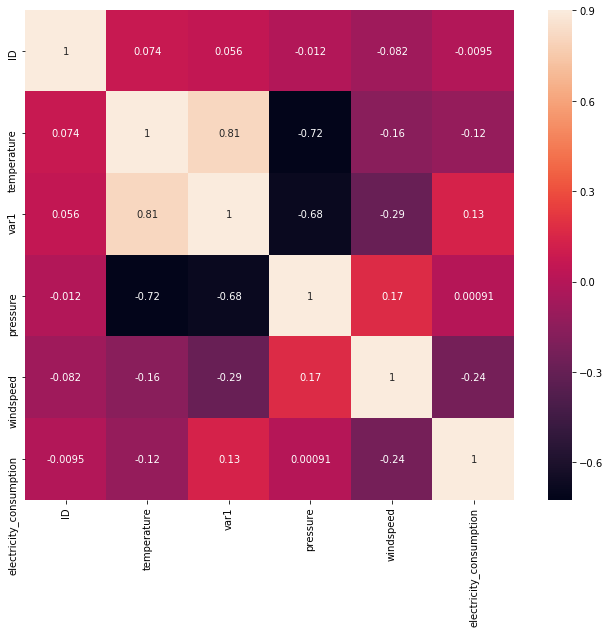

In [3]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True,annot=True)

In [4]:
train.describe()

,ID,temperature,var1,pressure,windspeed,electricity_consumption
count,26496.000000,26496.000000,26496.000000,26496.000000,26496.000000,26496.000000
mean,17455.500000,5.098989,-1.916233,986.450615,23.959956,298.359601
std,10122.873673,8.682860,10.424860,12.002647,48.280321,108.020555
min,0.000000,-17.100000,-32.900000,953.000000,1.075000,174.000000
25%,8717.750000,-2.900000,-10.700000,978.000000,3.155000,219.000000
50%,17435.500000,6.400000,-1.400000,986.000000,6.545000,267.000000
75%,26177.250000,12.100000,7.900000,995.000000,22.260000,342.000000
max,34895.000000,23.600000,18.600000,1024.000000,586.600000,1386.000000


In [5]:
#train['electricity_consumption']=np.log1p(train['electricity_consumption'])

In [6]:
#train[train['electricity_consumption']>700]

In [7]:
train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [8]:
train['train_or_test']='train'
test['train_or_test']='test'
df=pd.concat([train,test])

C:\Users\ABetta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
def create_date_featues(df):

    df['Year'] = pd.to_datetime(df['datetime']).dt.year

    df['Month'] = pd.to_datetime(df['datetime']).dt.month

    df['Day'] = pd.to_datetime(df['datetime']).dt.day

    df['Dayofweek'] = pd.to_datetime(df['datetime']).dt.dayofweek

    df['DayOfyear'] = pd.to_datetime(df['datetime']).dt.dayofyear

    df['Week'] = pd.to_datetime(df['datetime']).dt.week

    df['Quarter'] = pd.to_datetime(df['datetime']).dt.quarter 

    #df['Is_month_start'] = pd.to_datetime(df['datetime']).dt.is_month_start

    #df['Is_month_end'] = pd.to_datetime(df['datetime']).dt.is_month_end

    #df['Is_quarter_start'] = pd.to_datetime(df['datetime']).dt.is_quarter_start

    #df['Is_quarter_end'] = pd.to_datetime(df['datetime']).dt.is_quarter_end

    #df['Is_year_start'] = pd.to_datetime(df['datetime']).dt.is_year_start

    #df['Is_year_end'] = pd.to_datetime(df['datetime']).dt.is_year_end

    df['Semester'] = np.where(df['Quarter'].isin([1,2]),1,2)

    df['Is_weekend'] = np.where(df['Dayofweek'].isin([5,6]),1,0)

    df['Is_weekday'] = np.where(df['Dayofweek'].isin([0,1,2,3,4]),1,0)

    df['Days_in_month'] = pd.to_datetime(df['datetime']).dt.days_in_month
    
    df['Hour'] = pd.to_datetime(df['datetime']).dt.hour

    return df

In [10]:
df=create_date_featues(df)

In [11]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [12]:
#aggcat=agg_categorical(df, 'Hour', "var")
#df=df.merge(aggcat,on='Hour',how='left')

In [13]:
def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    '''
    Creates various sales agg features with given agg functions  
    '''
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf

In [14]:
 agg_df = create_sales_agg_monthwise_features(df.loc[df.train_or_test=='train', :], 
                                              gpby_cols=['var2','Hour'], 
                                              target_col='electricity_consumption', 
                                              agg_funcs={'mean':np.mean, 
                                              'median':np.median, 'max':np.max, 
                                              'min':np.min, 'std':np.std})

In [15]:
df=df.merge(agg_df,on=['var2','Hour'],how='left')

In [16]:
train=df.loc[df.train_or_test.isin(['train'])]
test=df.loc[df.train_or_test.isin(['test'])]
train.drop(columns={'train_or_test','datetime'},axis=1,inplace=True)
test.drop(columns={'train_or_test','datetime'},axis=1,inplace=True)

C:\Users\ABetta\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [17]:
train=pd.get_dummies(train)
test=pd.get_dummies(test)

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        
        le.fit(train[col])
        # Transform both training and valing data
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
        le_count += 1
            
print('%d columns were label encoded.' % le_count)

0 columns were label encoded.


In [19]:
train[train['electricity_consumption']>1000]=1000
#train=train[train['electricity_consumption']<500]
train['electricity_consumption']=np.log1p(train['electricity_consumption'])

In [20]:
train.columns

Index(['ID', 'electricity_consumption', 'pressure', 'temperature', 'var1',
       'windspeed', 'Year', 'Month', 'Day', 'Dayofweek', 'DayOfyear', 'Week',
       'Quarter', 'Semester', 'Is_weekend', 'Is_weekday', 'Days_in_month',
       'Hour', 'electricity_consumption_mean',
       'electricity_consumption_median', 'electricity_consumption_max',
       'electricity_consumption_min', 'electricity_consumption_std', 'var2_A',
       'var2_B', 'var2_C'],
      dtype='object')

In [21]:
x_train=train.loc[:,['pressure', 'temperature',
       'var1', 'windspeed', 'Year', 'Month', 'Day', 'Dayofweek',
       'DayOfyear', 'Week', 'Quarter',
                     'Semester', 'Is_weekend', 'Is_weekday',
       'Hour','var2_A', 'var2_B', 'var2_C','electricity_consumption_mean', 'electricity_consumption_median',
       'electricity_consumption_max', 'electricity_consumption_min',
       'electricity_consumption_std']]
y_train=train.loc[:,['electricity_consumption']]
test=test.loc[:,['pressure', 'temperature',
       'var1', 'windspeed', 'Year', 'Month', 'Day', 'Dayofweek',
       'DayOfyear', 'Week', 'Quarter',
                 'Semester', 'Is_weekend', 'Is_weekday',
       'Hour','var2_A', 'var2_B', 'var2_C','electricity_consumption_mean', 'electricity_consumption_median',
       'electricity_consumption_max', 'electricity_consumption_min',
       'electricity_consumption_std']]

In [22]:
col=x_train.columns
from sklearn.preprocessing import StandardScaler
st=StandardScaler()
st.fit(x_train)
x_train=st.transform(x_train)
test=st.transform(test)

In [ ]:
x_train=pd.DataFrame(x_train,columns=col)
x_train1=x_train.copy()
x_train[x_train<0]=0
x_train1[x_train1>0]=0
x_train1=x_train1.add_suffix('_neg')
x_train=x_train.join(x_train1)

In [ ]:
test=pd.DataFrame(test,columns=col)
test1=test.copy()
test[test<0]=0
test1[test1>0]=0
test1=test1.add_suffix('_neg')
test=test.join(test1)

In [ ]:

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
    
    seed=42)

model.fit(
    x_train, 
    y_train)


[13:16:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
pred=model.predict(test)

from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=1000,n_jobs=-1,random_state=32)
rf.fit(x_train,y_train)
rfpred=rf.predict(test)

In [ ]:
len(test)

In [ ]:
sub['electricity_consumption']=np.expm1(pred)

In [ ]:
sub.to_csv('sub1.csv',index=False)

In [ ]:
plot_features(model,(20,30))

In [646]:
greater=sub[sub['electricity_consumption']>342]

In [647]:
greater.to_csv('greater.csv',index=False)

In [649]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [650]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
GBoost.fit(x_train,y_train)
gbpred=GBoost.predict(test)

C:\Users\ABetta\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [652]:
sub['electricity_consumption']=np.expm1(gbpred)

In [653]:
sub.to_csv('gbpred.csv',index=False) #78.97

In [655]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb.fit(x_train,y_train)
lgbpred=model_lgb.predict(test)

In [656]:
sub['electricity_consumption']=np.expm1(lgbpred)

In [657]:
sub.to_csv('lgbpred.csv',index=False) #83

In [678]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_xgb.fit(x_train,y_train)
lgbpred=model_xgb.predict(test)

In [679]:
sub['electricity_consumption']=np.expm1(lgbpred)
sub.to_csv('xgbpred.csv',index=False) #77.87